## Rejection Option-based Classfication (Image Data)

### Table of contents:
1. [Introduction](#1.-Introduction)
2. [Data preparation](#2.-Data-preparation)
3. [Train classifier network](#3.-Classifier-network)
	* [Model fairness](#Model-Fairness) 
4. [Mitigate the bias using ROC](#4.-Mitigate-the-bias-using-ROC)
	* [Estimate optimal parameters for the ROC method](#Estimate-optimal-parameters-for-the-ROC-method)
	* [Model Fairness after bias mitigation](#Model-Fairness-after-bias-mitigation)
5. [Summary](#5.-Summary)
6. [References](#6.-References)

### 1. Introduction

Welcome!

We hope you have had a chance to go through previous tutorials on "Fairness in AI" by Sony. In one of the tutorials, we applied `Rejection Option-based Classification (hereafter referred to as ROC)` technique after training the classifier on UCI Adult (Census) dataset. As a result, model fairness improved without causing significant drop in accuracy.

In this tutorial, we will explore ROC for a visual recognition task on CelebA dataset.

Let's start by installing NNabla and accessing [nnabla-examples repository](https://github.com/sony/nnabla-examples). If you're running notebook on Google Colab, make sure  Runtime setting is set as GPU, which can be set up from the top menu (Runtime → change runtime type). Click **Connect** on the top right-hand side of the screen before you start.

In [ ]:
# Preparation
# May show warnings for newly imported packages if run in Colab default python environment.
# Please click the `RESTART RUNTIME` to run the following script correctly.
# The error message of conflicts is acceptable.
!git clone https://github.com/sony/nnabla-examples.git
!pip install albumentations
!pip install nnabla-ext-cuda116

In [ ]:
%cd nnabla-examples/responsible_ai/rejection_option_based_classification_images

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('images/roc_workflow_diagram.png')
cv2_imshow(img)

As illustrated in the picture, we will train a classifier ML model, analyze model fairness and then show how ROC technique reduces bias in model predictions.

Import all the necessary python libraries:

In [1]:
import os
import glob
import pickle
import shutil
import numpy as np
from sklearn import metrics
from PIL import Image
import albumentations as A
import nnabla as nn
from nnabla.utils.data_iterator import data_iterator_simple
import classifier as clf
from utils import utils

2022-07-21 21:22:27,838 [nnabla][INFO]: Initializing CPU extension...


Let us train an `Blond_Hair` classifier that is not dependent on `Gender` expression. 

### 2. Data preparation

Before training a classifier model, let's download and split the CelebA dataset into three categories: training, validation and test sets.

In [ ]:
# download the celeba dataset and unzip
URL = "https://www.dropbox.com/s/d1kjpkqklf0uw77/celeba.zip?dl=0"
ZIP_FILE= "./data/celeba.zip"
!mkdir -p ./data/
!wget -N $URL -O $ZIP_FILE
!unzip $ZIP_FILE -d ./data/
!rm $ZIP_FILE

In [2]:
def split_celeba_dataset(img_path, attr_path, out_dir, split="test"):
    
    """
    split the celebA dataset
    Args:
        img_path (str): image path directory 
        attr_path (str): celebA attribute file path (ex: list_attr_celeba.txt)
        out_dir (str): Path where the split data to be saved
        split (string): split the dataset depends on the split attribute(train, valid, and test)
    """
    # as per the author's remark, we split the dataset
    train_beg = 0  # train starts from
    valid_beg = 162770  # valid starts from
    test_beg = 182610  # test starts from
    
    label_file = open(attr_path, 'r')
    label_file = label_file.readlines()
    
    # skipping the first two rows for header
    total_samples = len(label_file) - 2
    if split == 'train':
        number_samples = valid_beg - train_beg
        beg = train_beg
    
    elif split == 'valid':
        number_samples = test_beg - valid_beg
        beg = valid_beg
    
    elif split == 'test':
        number_samples = total_samples - test_beg
        beg = test_beg
    else:
        print('Error')
        return
    
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    
    for i in range(beg + 2, beg + number_samples + 2):
        temp = label_file[i].strip().split()
        src_dir = os.path.join(img_path,temp[0])
        dst_dir = os.path.join(out_dir,temp[0])
        shutil.copy(src_dir, dst_dir)
    print(f"splitting completed for {split} set")
    return out_dir

In [ ]:
source_image_dir = r'./data/celeba/images'
attr_path = r'./data/celeba/list_attr_celeba.txt'

# train_dir = split_celeba_dataset(img_path=source_image_dir, attr_path=attr_path, out_dir= r'./train',split="train")
valid_dir = split_celeba_dataset(img_path=source_image_dir, attr_path=attr_path, out_dir= r'./valid',split="valid")
test_dir = split_celeba_dataset(img_path=source_image_dir, attr_path=attr_path, out_dir= r'./test',split="test")

[CelebA](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) is a dataset with 2,02,599 celebrity face images, each with 40 binary attributes labels.

Let's first import basic modules to switch between CPU and GPU.

In [4]:
from nnabla.ext_utils import get_extension_context
context = "cudnn" # for cpu set context as 'cpu'
device_id = 0
ctx = get_extension_context(context, device_id=device_id)
nn.set_default_context(ctx)

2022-07-21 21:25:08,266 [nnabla][INFO]: Initializing CUDA extension...
2022-07-21 21:25:09,539 [nnabla][INFO]: Initializing cuDNN extension...


Create train, validation & test data loaders to train the classifier model. In this tutorial we train a `Blond_Hair` classifier that does not depend on 'Gender' expression, which means 'target' attribute is `Blond_Hair` and 'protected' attribute is 'Male' in CelebA dataset (configure Target and Protected attributes in the data loader).

In [5]:
def data_iterator_celeba(img_path, attr_path, batch_size,
                         target_attribute ='Attractive', protected_attribute = 'Male', 
                         num_samples=-1, augment=False, shuffle=False, rng=None):
    """
    create celebA data iterator
    Args:
        img_path (str) : image path directory
        attr_path (str) : celebA attribute file path (ex: list_attr_celeba.txt)
        batch_size (int) :  number of samples contained in each generated batch
        target_attribute (str) : target attribute (ex: Arched EyeBrows, Bushy Eyebrows, smilling,etc..)
        protected_attribute (str): protected attribute (ex: Male, Pale_Skin)
        num_samples (int) : number of samples taken in data loader
                            (if num_samples=-1, it will take all the images in the dataset)
        augment (bool) : data augmentation (True for training)
        shuffle (bool) : shuffle the data (True /False)
        rng : None
    Returns:
        simple data iterator
    """

    imgs = []
    for file in sorted(os.listdir(img_path), key=lambda x: int(x.split(".")[0])):
        imgs.append(os.path.join(img_path,file))
    with open(attr_path, 'r') as f:
        lines = f.readlines()

    attr_list = lines[1].strip().split()
    attr_idx_dict = {attr: i for i, attr in enumerate(attr_list)}
    labels_dict = {}
    for line in lines[2:]:
        line = line.strip().split()
        key = line[0]
        attr = line[1:]
        labels_dict[key] = np.array([int((int(attr[attr_idx_dict[target_attribute]]) + 1) / 2), int((int(attr[attr_idx_dict[protected_attribute]]) + 1) / 2)])

    # transform image as published originally by authors
    # (resize to , 256×256, 224×224)
    pre_process = [(256, 256), (224, 224)]
    mean_normalize = (0.485, 0.456, 0.406)
    std_normalize = (0.229, 0.224, 0.225)

    if augment:
        transform = A.Compose([
            A.Resize(pre_process[0][0], pre_process[0][1]),
            A.RandomCrop(width=pre_process[1][0], height=pre_process[1][1]),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=mean_normalize, std=std_normalize)
        ])
    else:
        transform = A.Compose([
            A.Resize(pre_process[0][0], pre_process[0][1]),
            A.CenterCrop(width=pre_process[1][0], height=pre_process[1][1]),
            A.Normalize(mean=mean_normalize, std=std_normalize)
        ])
    if num_samples == -1:
        num_samples = len(imgs)
    else:
        print("Num. of data ({}) is used for debugging".format(num_samples))

    def load_func(i):
        img = Image.open(imgs[i])
        img = np.array(img.convert('RGB'))
        # transform
        transformed_image = transform(image=img)['image'].transpose(2, 0, 1)
        return transformed_image, labels_dict[os.path.basename(imgs[i])]

    return data_iterator_simple(load_func, num_samples, batch_size, shuffle=shuffle, rng=rng, with_file_cache=False)

In [6]:
val_loader = data_iterator_celeba(img_path= r'./valid',
                            attr_path= r'./data/celeba/list_attr_celeba.txt',
                            target_attribute ='Blond_Hair', protected_attribute = 'Male',
                            batch_size=32)
test_loader = data_iterator_celeba(img_path= r'./test',
                            attr_path= r'./data/celeba/list_attr_celeba.txt',
                            target_attribute ='Blond_Hair', protected_attribute = 'Male',
                            batch_size=32)

2022-07-21 21:26:34,349 [nnabla][INFO]: DataSource with shuffle(False)
2022-07-21 21:26:34,758 [nnabla][INFO]: Using DataIterator
2022-07-21 21:26:35,355 [nnabla][INFO]: DataSource with shuffle(False)
2022-07-21 21:26:35,373 [nnabla][INFO]: Using DataIterator


### 3. Classifier network

To train a classifier, we take [ResNet-50](https://nnabla.org/pretrained-models/nnp_models/imagenet/Resnet-50/Resnet-50.nnp) pre-trained on [ImageNet](https://image-net.org/) as base architecture. Fully connected layer in ResNet is replaced with two fully connected layers of size 2048. Drop-Out and ReLU are applied. We train all models with sigmoid cross-entropy loss for 20 epochs with a batch size of 32. We use [Adam](https://arxiv.org/abs/1412.6980) optimizer with a learning rate of 1e-3.

We have trained the Attribute Classifier and saved the model with the best accuracy on the validation set. Now let us get these pre-trained classifier weights and evaluate model fairness. 

PS:
If you want to train the Attribute Classifier from scratch, please refer to our GitHub page and follow the steps.

In [8]:
# download the pre-trained weights
!wget https://nnabla.org/pretrained-models/nnabla-examples/responsible_ai/rejection_option_based_classification_images/best_acc.h5
!wget https://nnabla.org/pretrained-models/nnabla-examples/responsible_ai/rejection_option_based_classification_images/val_results.pkl

--2022-07-21 21:29:21--  https://nnabla.org/pretrained-models/nnabla-examples/responsible_ai/rejection_option_based_classification_images/best_acc.h5
Resolving nnabla.org (nnabla.org)... 54.192.150.11, 54.192.150.66, 54.192.150.21, ...
Connecting to nnabla.org (nnabla.org)|54.192.150.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111384648 (106M) [application/x-hdf5]
Saving to: ‘best_acc.h5’

best_acc.h5         100%[===================>] 106.22M  8.92MB/s    in 11s     

2022-07-21 21:29:33 (9.32 MB/s) - ‘best_acc.h5’ saved [111384648/111384648]

--2022-07-21 21:29:33--  https://nnabla.org/pretrained-models/nnabla-examples/responsible_ai/rejection_option_based_classification_images/val_results.pkl
Resolving nnabla.org (nnabla.org)... 54.192.150.11, 54.192.150.66, 54.192.150.21, ...
Connecting to nnabla.org (nnabla.org)|54.192.150.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383 [binary/octet-stream]
Saving to: ‘val_results.

In [9]:
nn.clear_parameters()
attribute_classifier_model = clf.AttributeClassifier(model_load_path=r'./best_acc.h5')
cal_thresh = pickle.load(open(r'./val_results.pkl', 'rb'))['cal_thresh']

2022-07-21 21:29:48,916 [nnabla][INFO]: Downloading Resnet-50.nnp from https://nnabla.org/pretrained-models/nnp_models/imagenet/Resnet-50/Resnet-50.nnp
2022-07-21 21:29:50,319 [nnabla][INFO]: > /home/ubuntu/nnabla_data/nnp_models/imagenet/Resnet-50.nnp already exists.
2022-07-21 21:29:50,320 [nnabla][INFO]: > If you have any issue when using this file, 
2022-07-21 21:29:50,322 [nnabla][INFO]: > manually remove the file and try download again.


Loading /home/ubuntu/nnabla_data/nnp_models/imagenet/Resnet-50.nnp.


### Model Fairness

Let's start our investigation of classifier model fairness by analyzing the test and validation set prediction scores, depending on the optimal classification threshold. In one of the [earlier tutorials](https://github.com/sony/nnabla-examples/tree/master/responsible_ai/three_metrics), we have shown how to measure model fairness using different fairness criteria (Demographic parity, Equal opportunity & Equalized odds).

Get model fairness with respect to sensitive attribute.

In [10]:
val_targets, val_scores = attribute_classifier_model.get_scores(val_loader)
test_targets, test_scores = attribute_classifier_model.get_scores(test_loader)
val_pred = np.where(val_scores > cal_thresh, 1, 0)
test_pred = np.where(test_scores > cal_thresh, 1, 0)

#### Model Fairness on Validation set 

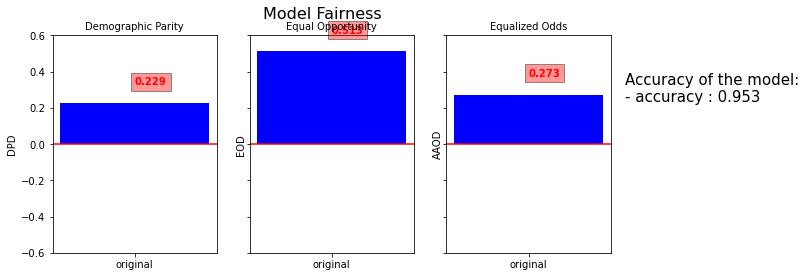

In [11]:
DPD,EOD,AAOD =  utils.get_fairness(val_targets[:, 0], val_targets[:, 1] == 1, val_pred)
accuracy = metrics.accuracy_score(val_targets[:, 0], val_pred)
utils.plot_fairness_multi(DPD, EOD, AAOD, accuracy, bar_x_axis="original")

#### Model Fairness on Test set 

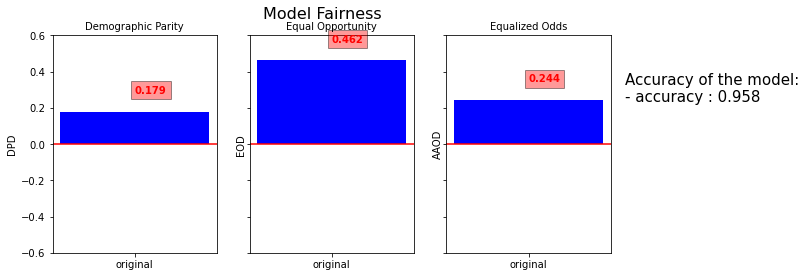

In [12]:
DPD, EOD, AAOD =  utils.get_fairness(test_targets[:, 0], test_targets[:, 1] == 1, test_pred)
accuracy = metrics.accuracy_score(test_targets[:, 0], test_pred)
utils.plot_fairness_multi(DPD, EOD, AAOD, accuracy, bar_x_axis="original")

As seen above, predictions are not fair when considered in the context of `Male` as a sensitive/protected attribute.

Now let's mitigate the bias using `Rejection Option-based Classification' technique.

## 4. Mitigate the bias using ROC

In this approach, assumption is that most discrimination occurs when a model is least certain of the prediction, i.e. around the decision boundary (classification threshold). For example, with a classification threshold of 0.5, if the model prediction is 0.81 or 0.1, we would consider the model certain of its prediction but for 0.51 or 0.49, the model is not certain about the chosen category. In ROC, favorable & unfavorable outcomes are adjusted for unprivileged & privileged groups in a confidence band around the decision boundary with highest uncertainty.

### Estimate optimal parameters for the ROC method

Please look at code below to estimate optimal parameters (optimal classification threshold and critical region boundary (ROC margin)) for desired constraint on fairness using ROC technique. 

Constraints can be used on following fairness measures:
* Statistical parity difference 
* Absolute Average odds difference
* Equal opportunity difference 

Best parameters are those that maximize the classification threshold while satisfying the fairness constraints.

In [13]:
from warnings import warn
def reject_option_classification(y_true, y_predicted_score,
                                 privileged_group, metric_name="DPD",
                                 metric_upper_bound=0.10, metric_lower_bound=0.05):
    """
    Reject option classification is a postprocessing technique that swaps outcomes
    between privileged and underprivileged groups near the decision boundary.
    Args:
        y_true (numpy.ndarray) : ground truth (correct) target values.
        y_predicted_score (numpy.ndarray) : estimated probability predictions (targets scores)
                                            as returned by a classifier.
        privileged_group (numpy.ndarray): list of privileged group values.
        metric_name (str) : name of the metric to use for the optimization
                            (DPD(Demographic parity difference,
                            AAOD (Absolute average odds difference),
                            EOD (Equal opportunity difference))
        metric_upper_bound (float) : upper bound of constraint on the metric value
        metric_lower_bound (float) : upper bound of constraint on the metric value

    Returns:
        ROC_margin (float): critical region boundary,
        classification_threshold (float) : optimal classification threshold
    """

    low_classification_threshold = 0.01  # smallest classification threshold
    high_classification_threshold = 0.99  # highest classification threshold
    # number of classification threshold b/w low class threshold and high class threshold
    number_classification_threshold = 100
    number_ROC_margin = 50  # number of relevant ROC margins to be used in the optimization search

    fair_metric_array = np.zeros(number_classification_threshold * number_ROC_margin)
    balanced_accuracy_array = np.zeros_like(fair_metric_array)
    ROC_margin_array = np.zeros_like(fair_metric_array)
    classification_threshold_array = np.zeros_like(fair_metric_array)
    count = 0
    # Iterate through class thresholds
    for class_thresh in np.linspace(low_classification_threshold,
                                    high_classification_threshold,
                                    number_classification_threshold):

        classification_threshold = class_thresh
        if class_thresh <= 0.5:
            low_ROC_margin = 0.0
            high_ROC_margin = class_thresh
        else:
            low_ROC_margin = 0.0
            high_ROC_margin = (1.0 - class_thresh)

        # Iterate through ROC margins
        for ROC_margin in np.linspace(
                low_ROC_margin,
                high_ROC_margin,
                number_ROC_margin):
            ROC_margin = ROC_margin
            # Predict using the current threshold and margin
            y_pred = predict(y_predicted_score, classification_threshold,
                             ROC_margin, privileged_group)
            acc = metrics.accuracy_score(y_true, y_pred)
            dpd, eod, aaod = utils.get_fairness(y_true, privileged_group, y_pred)
            ROC_margin_array[count] = ROC_margin
            classification_threshold_array[count] = classification_threshold
            balanced_accuracy_array[count] = acc
            if metric_name == "DPD":
                fair_metric_array[count] = dpd
            elif metric_name == "AAOD":
                fair_metric_array[count] = aaod
            elif metric_name == "EOD":
                fair_metric_array[count] = eod
            count += 1

    rel_inds = np.logical_and(fair_metric_array >= metric_lower_bound,
                              fair_metric_array <= metric_upper_bound)
    if any(rel_inds):
        best_ind = np.where(balanced_accuracy_array[rel_inds]
                            == np.max(balanced_accuracy_array[rel_inds]))[0][0]
    else:
        warn("Unable to satisy fairness constraints")
        rel_inds = np.ones(len(fair_metric_array), dtype=bool)
        best_ind = np.where(fair_metric_array[rel_inds]
                            == np.min(fair_metric_array[rel_inds]))[0][0]

    ROC_margin = ROC_margin_array[rel_inds][best_ind]
    classification_threshold = classification_threshold_array[rel_inds][best_ind]

    return ROC_margin, classification_threshold


def predict(y_predicted_score, classification_threshold, ROC_margin, privileged_group):
    """
    Obtain fair predictions with ROC method
    Args:
        y_predicted_score (numpy.ndarray): estimated probability predictions
                                           (targets score) as returned by a classifier.
        classification_threshold (float) : optimal classification threshold
        ROC_margin (float) : critical region boundary
        privileged_group (numpy.ndarray) : list of privileged group values.
    Returns:
        y_pred numpy.ndarray: predictions using ROC method.
    """

    y_pred = np.where(y_predicted_score > classification_threshold, 1, 0)

    # Indices of critical region around the classification boundary
    critical_region_indices = np.logical_and(
        y_predicted_score <= classification_threshold + ROC_margin,
        y_predicted_score > classification_threshold - ROC_margin)

    # Indices of privileged and unprivileged groups
    cond_priv = privileged_group
    cond_unpriv = privileged_group == False
    y_pred[np.logical_and(critical_region_indices,
                          cond_priv)] = 0
    y_pred[np.logical_and(critical_region_indices,
                          cond_unpriv)] = 1

    return y_pred

So let's estimate the optimal classification threshold, and the critical region boundary (ROC margin) using validation set for the desired constraint on fairness.

In this tutorial, we have used `Demographic parity difference(DPD)` as a fairness constraint.

In [14]:
metric_name = "DPD"
ROC_margin, classification_threshold = reject_option_classification(val_targets[:, 0],val_scores,val_targets[:, 1] == 1,
                metric_name=metric_name)
print(ROC_margin, classification_threshold)

0.008101422387136691 0.9603030303030302


### Model Fairness after bias mitigation

#### Model Fairness on Val set
Let's obtain the predictions fpr validation data using estimated optimal classification threshold, compute accuracy and fairness metrics.

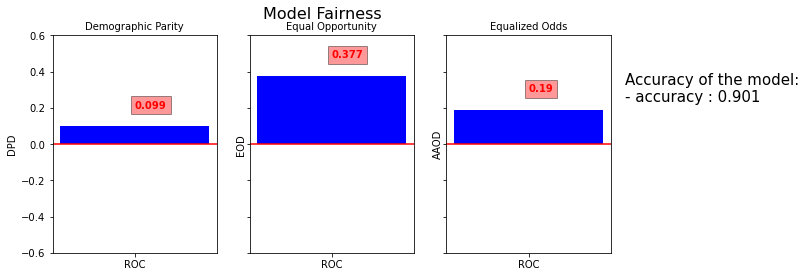

In [15]:
pred = predict(val_scores, classification_threshold, ROC_margin,val_targets[:, 1] == 1)
accuracy = metrics.accuracy_score(val_targets[:, 0], pred)
DPD, EOD, AAOD = utils.get_fairness(val_targets[:, 0],val_targets[:, 1] == 1, pred)
utils.plot_fairness_multi(DPD, EOD, AAOD, accuracy, bar_x_axis="ROC")

#### Model Fairness on Test set
Let's obtain predictions for test data using estimated optimal classification threshold, compute accuracy and fairness metrics now.

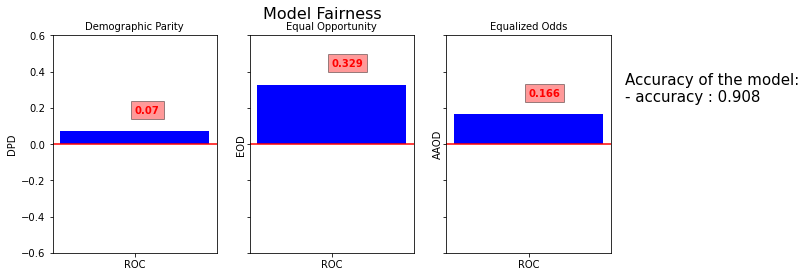

In [16]:
pred = predict(test_scores,classification_threshold,ROC_margin,test_targets[:, 1] == 1)
accuracy = metrics.accuracy_score(test_targets[:, 0], pred)
DPD, EOD, AAOD = utils.get_fairness(test_targets[:, 0],test_targets[:, 1] == 1, pred)
utils.plot_fairness_multi(DPD, EOD, AAOD, accuracy, bar_x_axis="ROC")

Plots above show how model fairness improved after induction of ROC at prediction time. DEO, EOD & AAOD scores have improved as compared to the baseline classifier model, but model accuracy dropped by 0.5%. To achieve this reduction in bias, the decision-makers should consider the trade-off between accuracy and fairness.

### 5. Summary

In this tutorial, we have shown how to reduce the bias at prediction time using Reject Option-based Classification procedure in a visual recognition task. In comparison to in-processing methods like Adversarial debiasing, experiments show that in-processing techniques like Prejudice Remover Regularizer are more effective at reducing bias than post-processing techniques such as ROC. However, advantage of this method is: ML practitioners could directly intervene at the last stage of the modeling workflow without modifying the data or learning algorithm while effectively reducing the bias with acceptable accuracy.

### 6. References

1. "Decision theory for discrimination-aware classification". Kamiran, Faisal, Asim Karim, and Xiangliang Zhang. In 2012 IEEE 12th International Conference on Data Mining, pp. 924-929. IEEE, 2012
2. "Equality of opportunity in supervised learning". Hardt, Moritz, Eric Price, and Nati Srebro. Advances in neural information processing systems 29 (2016)
3. "Adam: A method for stochastic optimization". Kingma, Diederik P., and Jimmy Ba. arXiv preprint arXiv:1412.6980 (2014).
4. "Large-scale celebfaces attributes (celeba) dataset". Liu, Ziwei, Ping Luo, Xiaogang Wang, and Xiaoou Tang. Retrieved August 15, no. 2018 (2018): 11.
5. "AI Fairness 360: An extensible toolkit for detecting and mitigating algorithmic bias".Bellamy RK, Dey K, Hind M, Hoffman SC, Houde S, Kannan K, Lohia P, Martino J, Mehta S, Mojsilović A, Nagar S. IBM Journal of Research and Development, 63(4/5), pp.4-1